In [1]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
import io
import pickle
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from itertools import combinations, chain
from torch.utils.data import TensorDataset, DataLoader
from collections import Counter
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [2]:
gauth = GoogleAuth()
gauth.DEFAULT_SETTINGS['client_config_file'] = 'client_secret_1057507276332-5mk9ac9q22rsmtm1idlqvpraq08ar8p5.apps.googleusercontent.com.json'
gauth.LoadCredentialsFile("mycreds.txt")
if gauth.credentials is None:
    gauth.LocalWebserverAuth()
elif gauth.access_token_expired:
    gauth.Refresh()
else:
    gauth.Authorize()

gauth.SaveCredentialsFile("mycreds.txt")
drive = GoogleDrive(gauth)

In [3]:
max_games = 500000 
asset_dir = 'asset'
file_name = '2023_tc_50000_games.pgn'

cached_urls_file = file_name.split('.')[0] + '_urls_list.pkl'
cached_ratings_file = file_name.split('.')[0] + '_ratings_list.pkl'
cached_games_file = file_name.split('.')[0] + '_game_arrays.pkl'

In [4]:
def load_item_from_file(file_path):
    if os.path.exists(file_path):
        print('loading item from cache...')
        with open(file_path, 'rb') as file:
            items = pickle.load(file)
        print('loaded')
        return items
    else:
        return None

try:
    assets_path = os.path.join(os.getcwd(), asset_dir)
    cached_urls_path = os.path.join(assets_path, cached_urls_file)
    cached_ratings_path = os.path.join(assets_path, cached_ratings_file)
    cached_games_path = os.path.join(assets_path, cached_games_file)
    urls_list = load_item_from_file(cached_urls_path)
    ratings_list = load_item_from_file(cached_ratings_path)
    game_arrays = load_item_from_file(cached_games_path)
except:
    print('Files not on disk, reading from drive...')
    urls_list = None
    ratings_list = None
    game_arrays = None

In [5]:
def find_folder_id(folder_name):
    """Find and return the Google Drive folder ID for a given folder name."""
    file_list = drive.ListFile({'q': f"title='{folder_name}' and mimeType='application/vnd.google-apps.folder' and trashed=false"}).GetList()
    for file in file_list:
        if file['title'] == folder_name:
            return file['id']
    return None

def read_pkl_file_from_drive(file_title, parent_id):
    """Read a .pkl file directly from Google Drive into a Python object."""
    query = f"'{parent_id}' in parents and trashed=false and title='{file_title}'"
    file_list = drive.ListFile({'q': query}).GetList()
    if not file_list:
        print(f"No file found with title: {file_title}")
        return None
    file = file_list[0]
    file_content = file.GetContentString(encoding='cp437')
    buffer = io.BytesIO(file_content.encode('cp437'))
    return pickle.load(buffer)

asset_folder_id = find_folder_id(asset_dir)
if asset_folder_id is None:
    print("Asset folder not found.")
elif game_arrays is not None:
    pass
else:
    file_titles = {
        'urls_list': cached_urls_file,
        'ratings_list': cached_ratings_file,
        'game_arrays': cached_games_file,
    }

    urls_list = read_pkl_file_from_drive(file_titles['urls_list'], asset_folder_id)
    ratings_list = read_pkl_file_from_drive(file_titles['ratings_list'], asset_folder_id)
    game_arrays = read_pkl_file_from_drive(file_titles['game_arrays'], asset_folder_id)

if urls_list is not None:
    print("URLs list loaded successfully.")
if ratings_list is not None:
    print("Ratings list loaded successfully.")
if game_arrays is not None:
    print("Game arrays loaded successfully.")

##2m 26.4s

URLs list loaded successfully.
Ratings list loaded successfully.
Game arrays loaded successfully.


In [6]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, hidden_size)
        self.fc6 = nn.Linear(hidden_size, hidden_size)
        self.fc7 = nn.Linear(hidden_size, hidden_size)
        self.fc_classification = nn.Linear(hidden_size, num_classes)
        self.fc_regression = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 

        out, _ = self.lstm(x, (h0,c0))  
        out = out[:, -1, :]
        
        out = self.dropout(F.relu(self.fc1(out)))
        out = self.dropout(F.relu(self.fc2(out)))
        out = self.dropout(F.relu(self.fc3(out)))
        out = self.dropout(F.relu(self.fc4(out)))
        out = self.dropout(F.relu(self.fc5(out)))
        out = self.dropout(F.relu(self.fc6(out)))
        out = self.dropout(F.relu(self.fc7(out)))
        classification_output = self.fc_classification(out)
        regression_output = self.fc_regression(out)
        return classification_output, regression_output

In [7]:
def combined_loss(classification_output, regression_output, target, alpha=0.5):
    classification_loss = nn.CrossEntropyLoss()(classification_output, target)
    regression_target = target.float()
    regression_loss = nn.MSELoss()(regression_output.squeeze(), regression_target)
    return alpha * classification_loss + (1 - alpha) * regression_loss

def train_model(model, train_loader, test_loader, optimizer, num_epochs, device, alpha=0.5):
    torets = []
    for epoch in range(num_epochs):
        model.train()
        for i, (moves, labels) in enumerate(train_loader):  
            moves = moves.to(device)
            labels = labels.to(device)

            classification_output, regression_output = model(moves)
            loss = combined_loss(classification_output, regression_output, labels, alpha)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        #print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
        predicted_probs, predicted_labels, actual_labels = test_model(model, test_loader, device)
        pred_closeness = [sum(abs(p - a) <= k for p, a in zip(predicted_labels, actual_labels)) for k in range(10)]
        toret = [x/20000 for x in pred_closeness]
        torets.append(toret)
    return torets

def test_model(model, test_loader, device):
    model.eval()
    n_correct = 0
    n_samples = 0
    predicted_probs = []
    predicted_labels = []
    actual_labels = []
    with torch.no_grad():
        for moves, labels in test_loader:
            moves = moves.to(device)
            labels = labels.to(device)
            classification_output, _ = model(moves)
            probabilities = F.softmax(classification_output, dim=1)

            _, predicted = torch.max(classification_output.data, 1)
            predicted_probs.extend(probabilities.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())
            actual_labels.extend(labels.cpu().numpy())
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    #print(f'Accuracy of the network on the test moves: {acc} %')
    return predicted_probs, predicted_labels, actual_labels

In [8]:
def pad_game(game, max_length=256, vector_size=42):
    padding_length = max_length - len(game)
    if padding_length < 0:
        return game[:max_length]
    else:
        padding = np.full((padding_length, vector_size), -1)
        return np.vstack((game, padding))

In [9]:
def get_loaders(padded_games, ratings_list, urls_list, batch_size, fold_number=0):
    if fold_number < 0 or fold_number > 4:
        raise ValueError("fold_number must be between 0 and 4")
    test_list = padded_games[fold_number::5]
    #print(len(test_list))
    train_list = [df for i in range(5) if i != fold_number for df in padded_games[i::5]]
    test_ratings = ratings_list[fold_number::5]
    train_ratings = [ratings for i in range(5) if i != fold_number for ratings in ratings_list[i::5]]
    test_urls = urls_list[fold_number::5]
    train_urls = [url for i in range(5) if i != fold_number for url in urls_list[i::5]]

    train_data = [torch.FloatTensor(doc) for doc in train_list]
    test_data = [torch.FloatTensor(doc) for doc in test_list]
    train_labels = torch.LongTensor(train_ratings)
    test_labels = torch.LongTensor(test_ratings)

    train_dataset = TensorDataset(torch.stack(train_data), train_labels)
    test_dataset = TensorDataset(torch.stack(test_data), test_labels)
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, train_urls, test_urls

In [10]:
input_size = 42
num_classes = 10
num_epochs = 40
sequence_length = 128
batch_size = 100
hidden_size = 100
num_layers = 3
learning_rate = 0.0008
alpha = 0.9
dropout_rate = 0
decay = 0.0001

torch.manual_seed(64)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name(i))

device: cuda
Tesla V100-PCIE-16GB


In [11]:
def get_ablation_stats():
    piece_indices = [0, 1, 2, 4, 5, 9, 10, 11, 12, 14, 15, 27, 28, 29, 30, 31, 32] #17
    domain_indices = [13, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26] #12
    time_indices = [6, 7, 8, 33, 34, 35, 36] #7
    engine_indices = [3, 37, 38, 39, 40, 41] #6
    type_inds = [piece_indices, domain_indices, time_indices, engine_indices]
    ind_names = ['piece_indices', 'domain_indices', 'time_indices', 'engine_indices']

    model_configs = []
    accuracies_list = []
    deviations_list = []

    for r in range(1, len(type_inds) + 1):
        for combo in combinations(enumerate(type_inds), r):
            keep_indices = list(chain(*[c[1] for c in combo]))
            names = [ind_names[c[0]] for c in combo]

            input_size = len(keep_indices)
            game_arrays_trunc = [arr[:, keep_indices] for arr in game_arrays]
            padded_games = [pad_game(g, sequence_length, input_size) for g in game_arrays_trunc]
            acc_mat = []
            for fold_number in range(5):
                train_loader, test_loader, train_urls, test_urls = get_loaders(padded_games, ratings_list, urls_list, batch_size, fold_number)
                model_path = file_name.split('.')[0] + '_pred.pth'
                device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
                model = RNN(input_size, hidden_size, num_layers, num_classes, dropout_rate).to(device)
                optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=decay)
                num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
                print(f'Model: {names}, Parameters: {num_params:,}, Fold: {fold_number}')

                lists = train_model(model, train_loader, test_loader, optimizer, num_epochs, device, alpha)
                predicted_probs, predicted_labels, actual_labels = test_model(model, test_loader, device)
                pred_closeness = [sum(abs(p - a) <= k for p, a in zip(predicted_labels, actual_labels)) for k in range(10)]
                accuracies = [x/20000 for x in pred_closeness]
                acc_mat.append(accuracies)
            acc_mat = np.array(acc_mat)
            avg_accs = np.mean(acc_mat, axis=0)
            std_accs = np.std(acc_mat, axis=0)
            print(avg_accs)

            model_configs.append(names)
            accuracies_list.append(avg_accs)
            deviations_list.append(std_accs)

            truths_counter = Counter(actual_labels)
            preds_counter = Counter(predicted_labels)
            actual_df = pd.DataFrame(list(truths_counter.items()), columns=['Label', 'Actual Count'])
            predicted_df = pd.DataFrame(list(preds_counter.items()), columns=['Label', 'Predicted Count'])
            merged_df = pd.merge(actual_df, predicted_df, on='Label', how='outer').fillna(0)
            sorted_df = merged_df.set_index('Label').sort_index()
            corrects_list = []
            recall_list = []
            for i in range(10):
                indices = [index for index, value in enumerate(actual_labels) if value == i]
                totals = [predicted_labels[ind] for ind in indices]
                corrects = [value for value in totals if value == i]
                rate = len(corrects)/len(totals)
                corrects_list.append(len(corrects))
                recall_list.append(rate)

            sorted_df['Correct Predictions'] = corrects_list
            sorted_df['Identify Rate'] = pd.Series(recall_list).round(3)
            display(sorted_df.T)
            print()

            #203m40.8s
    return model_configs, accuracies_list, deviations_list

In [12]:
ablation_configs_file_path = 'ablation_configs.pkl'
ablation_accuracies_file_path = 'ablation_accuracies.pkl'
ablation_deviations_file_path = 'ablation_deviations.pkl'

try:
    with open(ablation_configs_file_path, 'rb') as file:
        model_configs = pickle.load(file)
        print("Successfully loaded ablation configurations!")

    with open(ablation_accuracies_file_path, 'rb') as file:
        accuracies_list = pickle.load(file)
        print("Successfully loaded ablation accuracies!")

    with open(ablation_deviations_file_path, 'rb') as file:
        deviations_list = pickle.load(file)
        print("Successfully loaded ablation deviations!")

except:
    print("Ablation files not found. It's ablating time.\n")
    model_configs, accuracies_list, deviations_list = get_ablation_stats()
    
    with open(ablation_configs_file_path, 'wb') as file:
        pickle.dump(model_configs, file)

    with open(ablation_accuracies_file_path, 'wb') as file:
        pickle.dump(np.array(accuracies_list), file)

    with open(ablation_deviations_file_path, 'wb') as file:
        pickle.dump(np.array(deviations_list), file)

Ablation files not found. It's ablating time.

Model: ['piece_indices'], Parameters: 281,011, Fold: 0
Model: ['piece_indices'], Parameters: 281,011, Fold: 1
Model: ['piece_indices'], Parameters: 281,011, Fold: 2
Model: ['piece_indices'], Parameters: 281,011, Fold: 3
Model: ['piece_indices'], Parameters: 281,011, Fold: 4
[0.24632 0.61349 0.81667 0.921   0.9702  0.98915 0.99648 0.99923 0.99991
 1.     ]


Label,0,1,2,3,4,5,6,7,8,9
Actual Count,1633.000,2142.000,2091.000,1983.000,2066.000,2109.000,2173.000,2095.000,2093.000,1615.000
Predicted Count,1893.000,2729.000,2997.000,302.000,1826.000,3370.000,915.000,1937.000,2913.000,1118.000
Correct Predictions,793.000,752.000,601.000,48.000,355.000,634.000,187.000,391.000,821.000,439.000
Identify Rate,0.486,0.351,0.287,0.024,0.172,0.301,0.086,0.187,0.392,0.272



Model: ['domain_indices'], Parameters: 279,011, Fold: 0
Model: ['domain_indices'], Parameters: 279,011, Fold: 1
Model: ['domain_indices'], Parameters: 279,011, Fold: 2
Model: ['domain_indices'], Parameters: 279,011, Fold: 3
Model: ['domain_indices'], Parameters: 279,011, Fold: 4
[0.22935 0.58293 0.78404 0.89887 0.95547 0.98285 0.99397 0.99831 0.99989
 1.     ]


Label,0,1,2,3,4,5,6,7,8,9
Actual Count,1633.000,2142.00,2091.000,1983.000,2066.000,2109.000,2173.000,2095.000,2093.000,1615.000
Predicted Count,1019.000,3178.00,642.000,3669.000,1533.000,3187.000,410.000,3207.000,1851.000,1304.000
Correct Predictions,514.000,920.00,151.000,632.000,271.000,557.000,73.000,573.000,489.000,449.000
Identify Rate,0.315,0.43,0.072,0.319,0.131,0.264,0.034,0.274,0.234,0.278



Model: ['time_indices'], Parameters: 277,011, Fold: 0
Model: ['time_indices'], Parameters: 277,011, Fold: 1
Model: ['time_indices'], Parameters: 277,011, Fold: 2
Model: ['time_indices'], Parameters: 277,011, Fold: 3
Model: ['time_indices'], Parameters: 277,011, Fold: 4
[0.19766 0.50505 0.69992 0.82338 0.90605 0.95402 0.98057 0.99508 0.99982
 1.     ]


Label,0,1,2,3,4,5,6,7,8,9
Actual Count,1633.000,2142.000,2091.000,1983.0,2066.00,2109.000,2173.000,2095.0,2093.000,1615.000
Predicted Count,1063.000,4964.000,3446.000,0.0,2830.00,2055.000,2564.000,0.0,2378.000,700.000
Correct Predictions,411.000,1080.000,454.000,0.0,351.00,278.000,407.000,0.0,554.000,288.000
Identify Rate,0.252,0.504,0.217,0.0,0.17,0.132,0.187,0.0,0.265,0.178



Model: ['engine_indices'], Parameters: 276,611, Fold: 0
Model: ['engine_indices'], Parameters: 276,611, Fold: 1
Model: ['engine_indices'], Parameters: 276,611, Fold: 2
Model: ['engine_indices'], Parameters: 276,611, Fold: 3
Model: ['engine_indices'], Parameters: 276,611, Fold: 4
[0.23005 0.57125 0.7731  0.89368 0.95636 0.98538 0.99605 0.99919 0.99994
 1.     ]


Label,0,1,2,3,4,5,6,7,8,9
Actual Count,1633.000,2142.000,2091.00,1983.0,2066.000,2109.000,2173.000,2095.000,2093.00,1615.000
Predicted Count,1911.000,3139.000,1730.00,0.0,3159.000,1996.000,2557.000,865.000,3454.00,1189.000
Correct Predictions,723.000,763.000,313.00,0.0,503.000,309.000,469.000,155.000,880.00,511.000
Identify Rate,0.443,0.356,0.15,0.0,0.243,0.147,0.216,0.074,0.42,0.316



Model: ['piece_indices', 'domain_indices'], Parameters: 285,811, Fold: 0
Model: ['piece_indices', 'domain_indices'], Parameters: 285,811, Fold: 1
Model: ['piece_indices', 'domain_indices'], Parameters: 285,811, Fold: 2
Model: ['piece_indices', 'domain_indices'], Parameters: 285,811, Fold: 3
Model: ['piece_indices', 'domain_indices'], Parameters: 285,811, Fold: 4
[0.26627 0.64409 0.84115 0.93558 0.97544 0.99115 0.99722 0.99935 0.99996
 1.     ]


Label,0,1,2,3,4,5,6,7,8,9
Actual Count,1633.000,2142.000,2091.000,1983.000,2066.000,2109.000,2173.000,2095.000,2093.000,1615.000
Predicted Count,1458.000,3050.000,1616.000,2819.000,1095.000,1199.000,2014.000,2677.000,3159.000,913.000
Correct Predictions,745.000,919.000,387.000,530.000,231.000,263.000,407.000,555.000,935.000,395.000
Identify Rate,0.456,0.429,0.185,0.267,0.112,0.125,0.187,0.265,0.447,0.245



Model: ['piece_indices', 'time_indices'], Parameters: 283,811, Fold: 0
Model: ['piece_indices', 'time_indices'], Parameters: 283,811, Fold: 1
Model: ['piece_indices', 'time_indices'], Parameters: 283,811, Fold: 2
Model: ['piece_indices', 'time_indices'], Parameters: 283,811, Fold: 3
Model: ['piece_indices', 'time_indices'], Parameters: 283,811, Fold: 4
[0.28455 0.68318 0.8744  0.95551 0.98447 0.99546 0.99868 0.9997  0.99999
 1.     ]


Label,0,1,2,3,4,5,6,7,8,9
Actual Count,1633.000,2142.000,2091.000,1983.000,2066.000,2109.000,2173.000,2095.000,2093.000,1615.0
Predicted Count,2148.000,2022.000,1709.000,2598.000,854.000,3031.000,2217.000,1669.000,2785.000,967.0
Correct Predictions,938.000,608.000,413.000,547.000,204.000,624.000,488.000,375.000,864.000,485.0
Identify Rate,0.574,0.284,0.198,0.276,0.099,0.296,0.225,0.179,0.413,0.3



Model: ['piece_indices', 'engine_indices'], Parameters: 283,411, Fold: 0
Model: ['piece_indices', 'engine_indices'], Parameters: 283,411, Fold: 1
Model: ['piece_indices', 'engine_indices'], Parameters: 283,411, Fold: 2
Model: ['piece_indices', 'engine_indices'], Parameters: 283,411, Fold: 3
Model: ['piece_indices', 'engine_indices'], Parameters: 283,411, Fold: 4
[0.28098 0.67022 0.86785 0.95403 0.98594 0.99613 0.99932 0.99989 1.
 1.     ]


Label,0,1,2,3,4,5,6,7,8,9
Actual Count,1633.00,2142.000,2091.000,1983.000,2066.000,2109.000,2173.000,2095.000,2093.000,1615.000
Predicted Count,2590.00,2545.000,1264.000,2213.000,1187.000,1684.000,3403.000,1231.000,1792.000,2091.000
Correct Predictions,1062.00,694.000,291.000,473.000,240.000,377.000,779.000,269.000,520.000,868.000
Identify Rate,0.65,0.324,0.139,0.239,0.116,0.179,0.358,0.128,0.248,0.537



Model: ['domain_indices', 'time_indices'], Parameters: 281,811, Fold: 0
Model: ['domain_indices', 'time_indices'], Parameters: 281,811, Fold: 1
Model: ['domain_indices', 'time_indices'], Parameters: 281,811, Fold: 2
Model: ['domain_indices', 'time_indices'], Parameters: 281,811, Fold: 3
Model: ['domain_indices', 'time_indices'], Parameters: 281,811, Fold: 4
[0.27596 0.65564 0.8489  0.93885 0.97752 0.99187 0.99762 0.99945 0.99995
 1.     ]


Label,0,1,2,3,4,5,6,7,8,9
Actual Count,1633.000,2142.000,2091.000,1983.000,2066.000,2109.000,2173.000,2095.000,2093.000,1615.000
Predicted Count,1580.000,3077.000,960.000,1683.000,1675.000,4353.000,1221.000,2046.000,1583.000,1822.000
Correct Predictions,799.000,937.000,254.000,359.000,348.000,869.000,254.000,489.000,458.000,749.000
Identify Rate,0.489,0.437,0.121,0.181,0.168,0.412,0.117,0.233,0.219,0.464



Model: ['domain_indices', 'engine_indices'], Parameters: 281,411, Fold: 0
Model: ['domain_indices', 'engine_indices'], Parameters: 281,411, Fold: 1
Model: ['domain_indices', 'engine_indices'], Parameters: 281,411, Fold: 2
Model: ['domain_indices', 'engine_indices'], Parameters: 281,411, Fold: 3
Model: ['domain_indices', 'engine_indices'], Parameters: 281,411, Fold: 4
[0.27142 0.65407 0.85721 0.94827 0.98327 0.99534 0.99877 0.99978 0.99998
 1.     ]


Label,0,1,2,3,4,5,6,7,8,9
Actual Count,1633.000,2142.00,2091.00,1983.000,2066.000,2109.000,2173.000,2095.00,2093.000,1615.00
Predicted Count,1346.000,3358.00,1626.00,2387.000,2658.000,1434.000,2974.000,2057.00,1482.000,678.00
Correct Predictions,698.000,985.00,376.00,462.000,527.000,282.000,647.000,503.00,534.000,356.00
Identify Rate,0.427,0.46,0.18,0.233,0.255,0.134,0.298,0.24,0.255,0.22



Model: ['time_indices', 'engine_indices'], Parameters: 279,411, Fold: 1
Model: ['time_indices', 'engine_indices'], Parameters: 279,411, Fold: 2
Model: ['time_indices', 'engine_indices'], Parameters: 279,411, Fold: 3
Model: ['time_indices', 'engine_indices'], Parameters: 279,411, Fold: 4
[0.25514 0.62013 0.81535 0.91901 0.96828 0.98961 0.99718 0.99959 0.99998
 1.     ]


Label,0,1,2,3,4,5,6,7,8,9
Actual Count,1633.000,2142.000,2091.000,1983.000,2066.000,2109.0,2173.000,2095.000,2093.000,1615.000
Predicted Count,2047.000,4153.000,2422.000,603.000,1707.000,2278.0,2424.000,196.000,3220.000,950.000
Correct Predictions,826.000,968.000,437.000,108.000,304.000,421.0,483.000,47.000,927.000,502.000
Identify Rate,0.506,0.452,0.209,0.054,0.147,0.2,0.222,0.022,0.443,0.311



Model: ['piece_indices', 'domain_indices', 'time_indices'], Parameters: 288,611, Fold: 0
Model: ['piece_indices', 'domain_indices', 'time_indices'], Parameters: 288,611, Fold: 1
Model: ['piece_indices', 'domain_indices', 'time_indices'], Parameters: 288,611, Fold: 2
Model: ['piece_indices', 'domain_indices', 'time_indices'], Parameters: 288,611, Fold: 3
Model: ['piece_indices', 'domain_indices', 'time_indices'], Parameters: 288,611, Fold: 4
[0.30798 0.71665 0.89667 0.96559 0.98924 0.99656 0.99916 0.99983 0.99994
 1.     ]


Label,0,1,2,3,4,5,6,7,8,9
Actual Count,1633.000,2142.000,2091.000,1983.000,2066.000,2109.000,2173.000,2095.000,2093.000,1615.000
Predicted Count,1717.000,1890.000,2003.000,1660.000,3107.000,1752.000,2057.000,2471.000,1955.000,1388.000
Correct Predictions,906.000,724.000,551.000,428.000,738.000,411.000,485.000,626.000,663.000,684.000
Identify Rate,0.555,0.338,0.264,0.216,0.357,0.195,0.223,0.299,0.317,0.424



Model: ['piece_indices', 'domain_indices', 'engine_indices'], Parameters: 288,211, Fold: 0
Model: ['piece_indices', 'domain_indices', 'engine_indices'], Parameters: 288,211, Fold: 1
Model: ['piece_indices', 'domain_indices', 'engine_indices'], Parameters: 288,211, Fold: 2
Model: ['piece_indices', 'domain_indices', 'engine_indices'], Parameters: 288,211, Fold: 3
Model: ['piece_indices', 'domain_indices', 'engine_indices'], Parameters: 288,211, Fold: 4
[0.29418 0.70002 0.88791 0.96289 0.98906 0.99697 0.99932 0.9999  0.99999
 1.     ]


Label,0,1,2,3,4,5,6,7,8,9
Actual Count,1633.000,2142.000,2091.000,1983.000,2066.000,2109.000,2173.000,2095.000,2093.000,1615.000
Predicted Count,675.000,3358.000,1535.000,1664.000,2212.000,2267.000,3460.000,1455.000,2614.000,760.000
Correct Predictions,422.000,1121.000,393.000,383.000,474.000,497.000,832.000,373.000,852.000,405.000
Identify Rate,0.258,0.523,0.188,0.193,0.229,0.236,0.383,0.178,0.407,0.251



Model: ['piece_indices', 'time_indices', 'engine_indices'], Parameters: 286,211, Fold: 0
Model: ['piece_indices', 'time_indices', 'engine_indices'], Parameters: 286,211, Fold: 1
Model: ['piece_indices', 'time_indices', 'engine_indices'], Parameters: 286,211, Fold: 2
Model: ['piece_indices', 'time_indices', 'engine_indices'], Parameters: 286,211, Fold: 3
Model: ['piece_indices', 'time_indices', 'engine_indices'], Parameters: 286,211, Fold: 4
[0.30832 0.72173 0.90399 0.97236 0.99203 0.99794 0.99956 0.99991 0.99998
 1.     ]


Label,0,1,2,3,4,5,6,7,8,9
Actual Count,1633.000,2142.000,2091.000,1983.000,2066.00,2109.000,2173.000,2095.000,2093.000,1615.000
Predicted Count,2639.000,1888.000,1881.000,2138.000,2066.00,1956.000,2349.000,1663.000,1300.000,2120.000
Correct Predictions,1152.000,572.000,518.000,485.000,496.00,454.000,598.000,488.000,448.000,949.000
Identify Rate,0.705,0.267,0.248,0.245,0.24,0.215,0.275,0.233,0.214,0.588



Model: ['domain_indices', 'time_indices', 'engine_indices'], Parameters: 284,211, Fold: 0
Model: ['domain_indices', 'time_indices', 'engine_indices'], Parameters: 284,211, Fold: 1
Model: ['domain_indices', 'time_indices', 'engine_indices'], Parameters: 284,211, Fold: 2
Model: ['domain_indices', 'time_indices', 'engine_indices'], Parameters: 284,211, Fold: 3
Model: ['domain_indices', 'time_indices', 'engine_indices'], Parameters: 284,211, Fold: 4
[0.30043 0.70963 0.89563 0.9679  0.99066 0.99763 0.9996  0.99995 1.
 1.     ]


Label,0,1,2,3,4,5,6,7,8,9
Actual Count,1633.000,2142.000,2091.000,1983.000,2066.00,2109.000,2173.000,2095.000,2093.000,1615.000
Predicted Count,1505.000,2246.000,2056.000,2091.000,2198.00,1994.000,3752.000,591.000,2441.000,1126.000
Correct Predictions,795.000,776.000,529.000,474.000,475.00,467.000,882.000,150.000,832.000,608.000
Identify Rate,0.487,0.362,0.253,0.239,0.23,0.221,0.406,0.072,0.398,0.376



Model: ['piece_indices', 'domain_indices', 'time_indices', 'engine_indices'], Parameters: 291,011, Fold: 0
Model: ['piece_indices', 'domain_indices', 'time_indices', 'engine_indices'], Parameters: 291,011, Fold: 1
Model: ['piece_indices', 'domain_indices', 'time_indices', 'engine_indices'], Parameters: 291,011, Fold: 2
Model: ['piece_indices', 'domain_indices', 'time_indices', 'engine_indices'], Parameters: 291,011, Fold: 3
Model: ['piece_indices', 'domain_indices', 'time_indices', 'engine_indices'], Parameters: 291,011, Fold: 4
[0.32615 0.74754 0.9187  0.97686 0.99387 0.99833 0.99962 0.99995 1.
 1.     ]


Label,0,1,2,3,4,5,6,7,8,9
Actual Count,1633.000,2142.000,2091.000,1983.000,2066.000,2109.0,2173.000,2095.00,2093.000,1615.000
Predicted Count,1871.000,2104.000,2219.000,1377.000,1989.000,2536.0,2997.000,1627.00,2741.000,539.000
Correct Predictions,968.000,757.000,647.000,340.000,461.000,633.0,759.000,460.00,980.000,350.000
Identify Rate,0.593,0.353,0.309,0.171,0.223,0.3,0.349,0.22,0.468,0.217


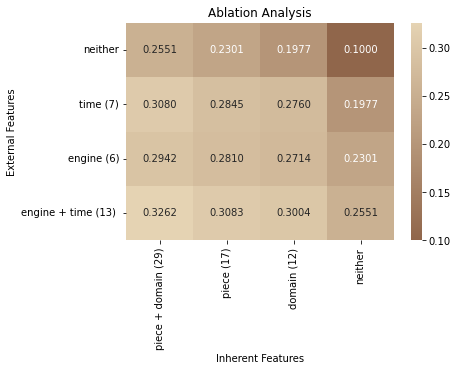

In [13]:
c_a_dict = {c: a[0] for (c,a) in zip(['__'.join(c) for c in model_configs], accuracies_list)}
c_a_dict["none"] = 0.1

x_labels = ["piece + domain (29)", "piece (17)", "domain (12)", "neither"]
y_labels = ["engine + time (13) ", "engine (6)", "time (7)", "neither"][::-1]
accs = [[v for v in c_a_dict.values()][i] for i in [14, 12, 13, 9, 11, 6, 8, 3, 10, 5, 7, 2, 9, 3, 2, 15]]

darkest_hex = "#90664b"
lightest_hex = "#e5d3b3"
custom_cmap = LinearSegmentedColormap.from_list("custom_blue", [darkest_hex, lightest_hex])

array_2d = np.array(accs).reshape(4,4)[::-1]
sns.heatmap(array_2d, annot=True, cmap=custom_cmap, fmt=".4f", xticklabels=x_labels, yticklabels=y_labels)
plt.xlabel("Inherent Features")
plt.ylabel("External Features")
plt.title("Ablation Analysis")
plt.show()
